In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 500)


In [2]:
# Read in average personal finance data
pf = pd.read_csv('average_personal_income_and_expense.csv', index_col=0, parse_dates=True)
pf.dropna(axis=1, inplace=True)


In [3]:
# Sample onto daily timeframe
daily_pf = pf.resample('D', how='mean').interpolate(method='polynomial', order=5, limit_direction='both')


In [4]:
# Get the % change from data
daily_pf_change = daily_pf.pct_change()
daily_pf_change = daily_pf_change.iloc[1:]
daily_pf_change = daily_pf_change.replace('inf',1)

In [5]:
# Create Normal models from data
models = {}
for col, data in daily_pf_change.iteritems():
    mu, std = norm.fit(data.dropna())
    models[col] = {
        'mu': mu,
        'std': std
    }


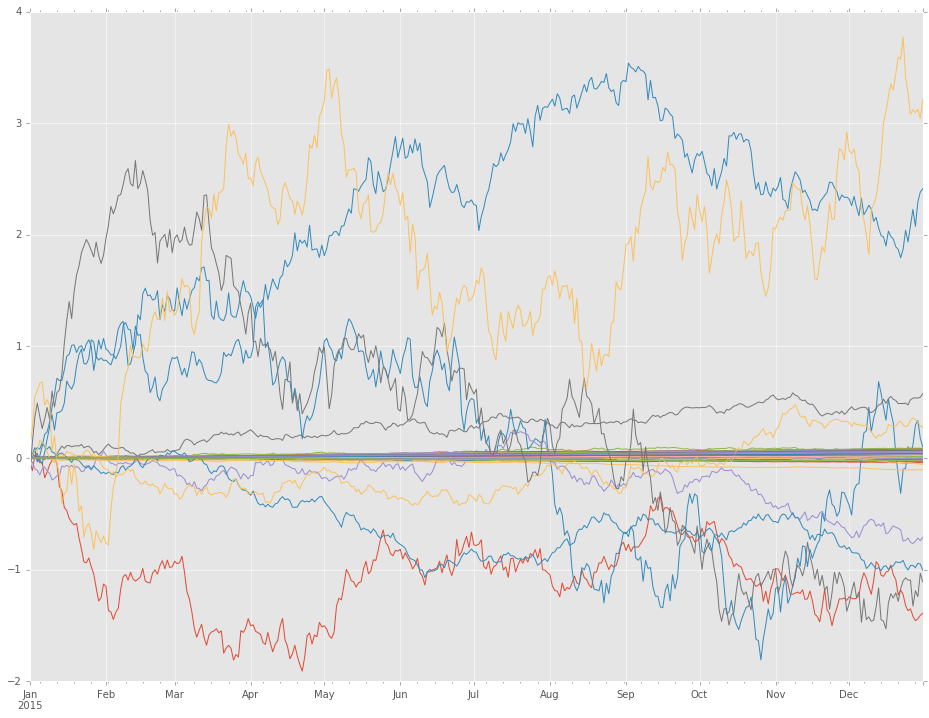

In [15]:
# Create random % changes for future
number_of_days_to_sim = 365
date_range = pd.date_range(start='2015-01-01', freq='D', periods=number_of_days_to_sim)
rand_df = pd.DataFrame(None, columns=pf.columns, index=date_range)

for col in pf:
    rvs = norm.rvs(models[col]['mu'], models[col]['std'], size=number_of_days_to_sim)
    rand_df[col] = rvs

# Display result
rand_df.cumsum().plot(legend=False)
